# Web Scraping de datos meteorológicos

Para este proyecto desarrollé mi primer web scraping para recoletar datos de la Estación Meteorológica Automática de la Universidad Nacional de San Martín (EMA-UNSAM). Se utilizó Python y las librerías BeautifulSoup, Schedule y Pandas para extraer los datos cada cierto período de tiempo y exportarlos a un archivo CSV. <br>

La elección de los datos a extraer fue solo por fines prácticos y de aprendizaje, sin embargo espero que este proyecto sea útil para la recolección de datos en investigaciones meteorológicas/ambientales o en el desarrollo de otras ideas.

### EMA - UNSAM

La EMA de la Universidad Nacional de San Martín, instalada en la terraza del edificio del 3iA (Instituto de Investigación e Ingeniería Ambiental, Buenos Aires, Argentina), cuenta con sensores de temperatura y humedad, un barómetro para medir la presión, un pluviómetro para las lluvias y un anemómetro, que computa la dirección y la velocidad del viento. Tiene una [página web](https://ema.unsam.edu.ar/) donde se puede consultar el pronóstico local actualizado cada 30 de minutos. 

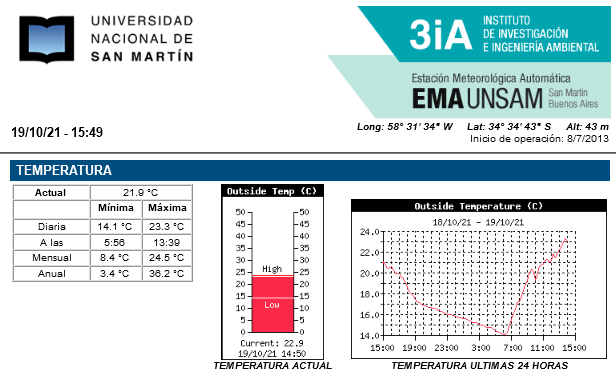 <br>
<br>
A continuación se describe el paso a paso del desarrollo del web scraper. Hacia el final, se presentan, a modo de ejemplo, algunos gráficos de una pequeña muestra de datos recogida entre el 18 y 19 de octubre de 2021.

## 1. Examinar datos de la EMA

En primer lugar, examiné los posibles datos a extraer y la estructura HTML de la página web. <br>

Decidí extraer los datos referidos a la temperatura (°C), humedad (%), punto de rocío (°C), presión barométrica (hPa), velocidad del viento (km/hr), lluvia (mm), radiación solar (W/m²), radiación uv (index), fecha (dd/mm/aa) y hora (hh:mm) de cada registro de la EMA. <br>

Luego creé un dataframe vacío para guardar los datos, y avancé al siguente paso: la extracción de datos.

In [1]:
import pandas as pd
cols = ["fecha", "temp", "hum", "p_rocio", "pres_bar", "viento", "lluvia", "r_solar", "r_uv"] 
df = pd.DataFrame(columns = cols)
datos = df.to_csv("datos_ema_unsam.csv", index = False)

## 2. Extraer datos

Al examinar la estructura de la página web, noté que la fecha y hora se encuentran en la etiqueta `<font>`, mientras que los datos meteorológicos en la etiqueta `<p>`.


In [2]:
import requests
import bs4 as bs

# Descarga el código HTML
url = requests.get("https://ema.unsam.edu.ar/")
soup = bs.BeautifulSoup(url.content, "html.parser")

In [3]:
# Extrae el contenido de las etiquetas donde se encuentra la fecha y hora de los datos
tags_font = soup.find_all("font", {"size":"3"})
# Crea una lista con el contenido de la etiqueta font
datos_font = [tag.text for tag in tags_font]

In [4]:
# ¿En que lugar se encuentran la fecha y hora en la lista "datos_font"? 
for i, d in enumerate(datos_font):
    print(i, ":", d)

0 : 25/10/21
1 : 17:49
2 :  TEMPERATURA
3 :  HUMEDAD
4 :  PUNTO
DE ROCIO
5 :  SENSACION
TERMICA
6 :  PRESION
BAROMETRICA
7 :  VIENTO
8 :  LLUVIA
9 :  ET
- EVAPOTRANSPIRACION
10 :  RADIACION
SOLAR
11 :  RADIACION
UV


In [5]:
# Extrae solo los datos de fecha y hora
fecha = " ".join(datos_font[0:2])
print("Fecha y Hora: ", fecha)

Fecha y Hora:  25/10/21 17:49


In [6]:
# Repite el mismo procedimiento para los datos meteorológicos
tags_p = soup.find_all("p", {"align":"center"})
datos_p = [tag.text for tag in tags_p]

In [7]:
# Como hay mas de 40 elementos en la lista "datos_p", paso a mostrar directamente la extracción de los datos.
# Con .split(" ")[0] recorto el string y me quedo sólo con los valores numéricos, dejando los símbolos de lado (°C, %, hPa...)
temp = datos_p[1].split(" ")[0]
hum = datos_p[6].split(" ")[0]
rocio = datos_p[11].split(" ")[0]
presion = datos_p[21].split(" ")[0]
viento = datos_p[24].split(" ")[0]
lluvia = datos_p[31].split(" ")[0]
r_solar = datos_p[37].split(" ")[0]
r_uv = datos_p[40].split(" ")[0]
print("Datos Meteorológicos: ", temp, hum, rocio, presion, viento, lluvia, r_solar, r_uv)

Datos Meteorológicos:  29.3 28 8.9 1010.5 1.6 0.0 174 2.0


## 3. Agregar datos al dataframe

El tercer paso fue agregar los datos en el dataframe creado anteriormente.

In [8]:
# Carga el archivo CSV
df = pd.read_csv("./datos_ema_unsam.csv")

In [9]:
# Crea una lista con todos los valores 
datos = [fecha, temp, hum, rocio, presion, viento, lluvia, r_solar, r_uv]

In [10]:
# Agrega los datos al df como una fila nueva
nueva_fila = pd.Series(datos, index = df.columns)
df = df.append(nueva_fila, ignore_index = True)
print(df)

            fecha  temp hum p_rocio pres_bar viento lluvia r_solar r_uv
0  25/10/21 17:49  29.3  28     8.9   1010.5    1.6    0.0     174  2.0


In [11]:
# Exporta el df a CSV
df.to_csv("datos_ema_unsam.csv", index = False)

## 4. Crear función extraer_ema()

Reuní el código del paso 2 y 3 en una función llamada `extraer_ema()`.
Esto lo hice con la idea de recoger datos cada una hora con la librería Schedule. El código completo se puede ver en [GitHub](https://github.com/mnrodriguez28/data-analysis-portfolio/blob/main/proyectos/ema-unsam-ws/ema_unsam_code.py).

## 5. Librería Schedule

Con Schedule llamo automáticamente a la función `extraer_ema()` y obtengo los datos cada una hora.

In [ ]:
import schedule
import time

schedule.every().hour.do(extraer_ema).run()

while True:
    schedule.run_pending()
    time.sleep(1)

## Visualización de los datos

In [12]:
# Importar librerías
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [13]:
# Cargar data
data = pd.read_csv("./ema_unsam.csv", index_col = "fecha", parse_dates = True)
data

,temp,hum,p_rocio,pres_bar,viento,lluvia,r_solar,r_uv
fecha,,,,,,,,
2021-10-18 03:20:00,16.6,62,9.2,1021.1,0.0,0.0,0,0.0
2021-10-18 04:19:00,16.2,64,9.3,1021.5,0.0,0.0,0,0.0
2021-10-18 05:20:00,14.6,72,9.6,1021.9,0.0,0.0,0,0.0
2021-10-18 06:19:00,14.0,79,10.4,1022.5,9.7,0.0,16,0.0
2021-10-18 07:20:00,14.2,80,10.8,1023.2,4.8,0.0,185,2.2
2021-10-18 08:20:00,15.7,76,11.4,1023.6,3.2,0.0,371,3.1
2021-10-18 09:19:00,17.4,70,11.9,1023.6,3.2,0.0,538,4.5
2021-10-18 10:19:00,19.2,63,12.0,1023.6,0.0,0.0,671,6.1
2021-10-18 11:19:00,20.7,57,11.9,1023.5,0.0,0.0,694,7.6


In [14]:
# Explorando los datos
data.describe()

,temp,hum,p_rocio,pres_bar,viento,lluvia,r_solar,r_uv
count,25.000000,25.00000,25.00000,25.000000,25.000000,25.0,25.000000,25.000000
mean,17.468000,70.16000,11.82400,1022.732000,1.348000,0.0,201.640000,2.244000
std,2.512588,8.52291,1.58936,0.818393,2.732691,0.0,277.125254,2.812188
min,14.000000,49.00000,9.20000,1021.100000,0.000000,0.0,0.000000,0.000000
25%,15.700000,68.00000,11.30000,1022.000000,0.000000,0.0,0.000000,0.000000
50%,16.600000,72.00000,11.70000,1022.900000,0.000000,0.0,16.000000,0.000000
75%,19.300000,76.00000,11.90000,1023.500000,0.000000,0.0,371.000000,4.300000
max,22.200000,80.00000,15.40000,1023.700000,9.700000,0.0,884.000000,8.400000


In [15]:
# ¿A que hora se registró el mayor índice de radiación uv?
max_ruv = data["r_uv"].max()
data[data["r_uv"] == max_ruv]["r_uv"]

fecha
2021-10-18 13:19:00    8.4
Name: r_uv, dtype: float64

In [16]:
# ¿A qué hora se registró la temperatura mínima?
min_temp = data["temp"].min()
data[data["temp"] == min_temp]["temp"]

fecha
2021-10-18 06:19:00    14.0
Name: temp, dtype: float64

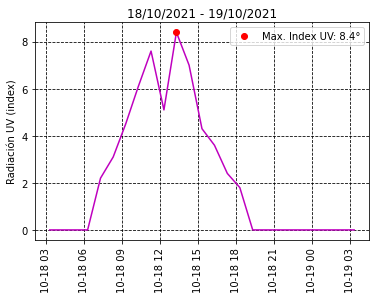

In [17]:
# Radiación UV 24hs
max_uv = data["r_uv"].max()
max_pos = data[data["r_uv"] ==  max_uv].index

plt.plot(data["r_uv"], "m-")
plt.plot(max_pos, max_uv, "ro", label = f"Max. Index UV: {max_uv}°")
plt.title("18/10/2021 - 19/10/2021")
plt.xticks(rotation = 90)
plt.ylabel("Radiación UV (index)")
plt.grid(True, c = "k", ls = "--")
plt.legend()

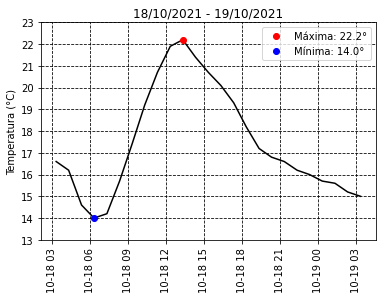

In [18]:
# Temperatura 24hs
max_temp = data["temp"].max()
max_pos = data[data["temp"] ==  max_temp].index

min_pos = data[data["temp"] == min_temp].index 

plt.plot(data["temp"], "k-")
plt.plot(max_pos, max_temp, "ro", label = f"Máxima: {max_temp}°")
plt.plot(min_pos, min_temp, "bo", label = f"Mínima: {min_temp}°")
plt.title("18/10/2021 - 19/10/2021")
plt.xticks(rotation = 90)
plt.yticks(np.arange(np.min(data["temp"])-1, np.max(data["temp"]+1), step=1))
plt.ylabel("Temperatura (°C)")
plt.grid(True, c = "k", ls = "--")
plt.legend()

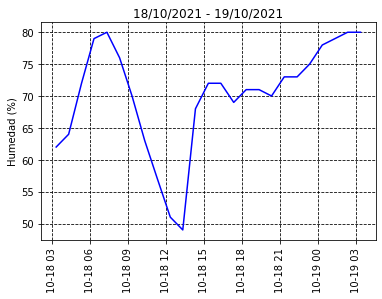

In [19]:
# Humedad 24hs.
plt.plot(data["hum"], "b-")
plt.title("18/10/2021 - 19/10/2021")
plt.xticks(rotation = 90)
plt.ylabel("Humedad (%)")
plt.grid(True, c = "k", ls = "--")

Observando los gráficos de temperatura y humedad, pareciera que cuando una variable aumenta, la otra disminuye.

Text(0, 0.5, 'Humedad (%)')

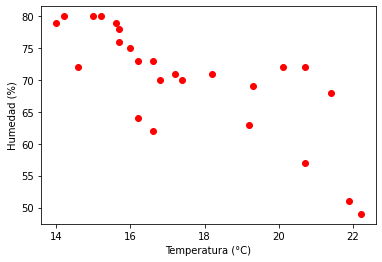

In [20]:
# Relación entre Temperatura y Humedad
plt.scatter(data["temp"], data["hum"], c = "r")
plt.xlabel("Temperatura (°C)")
plt.ylabel("Humedad (%)")

El diagrama de dispersión parece indicar una relación lineal negativa entre ambas variables. Con fines ilustrativos, se procede a calcular los coeficientes de correlación de Pearson y Spearman.

In [21]:
# Correlación
print("Correlación Pearson: ", data["temp"].corr(data["hum"], method="pearson"))
print("Correlación Spearman: ", data["temp"].corr(data["hum"], method="spearman"))


Correlación Pearson:  -0.7646120065639913
Correlación Spearman:  -0.8078713323424085


Los test estadísticos muestran una correlación lineal negativa entre moderada y alta: cuando aumenta la temperatura, la humedad disminuye y al disminuir la temperatura, la humedad aumenta.